In [4]:
# %reload_ext autoreload

In [5]:
%load_ext autoreload
%autoreload 1

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import numpy as np

from trampact.preprocess import get_data, drop_tx_columns
from trampact.plot import draw_hist

In [7]:
# Only run once 
%aimport trampact.preprocess
%aimport trampact.plot
%matplotlib inline

In [8]:
!pwd

/home/primitive/code/eangelid/trampact/notebooks


In [9]:
IRIS_T1_CSV = 'iris_T1.csv'
IRIS_T2_CSV = 'iris_T2.csv'
BD_GENT_2006 = 'BD_GENT_2006.csv'
BD_GENT_2016 = 'BD_GENT_2016.csv'

## Load ALL dataframes

#### Load T1 and T2 IRIS codes
Attn: The `get_data()` method automatically sets `iris_id` as the index

In [10]:
iris_T1 = get_data(IRIS_T1_CSV, is_local_csv=True)

In [11]:
iris_T2__full = get_data(IRIS_T2_CSV, is_local_csv=True)

In [12]:
# drop other columns - only keep index (iris_id) and IRIS label (name)
iris_T2 = pd.DataFrame(iris_T2__full['NOM_IRIS'])

#### Load demographic data

In [13]:
bd_gent_2006 = get_data(BD_GENT_2006, is_local_csv=True)

In [14]:
bd_gent_2016 = get_data(BD_GENT_2016, is_local_csv=True)

## Imputing
Do it here before creating new dataframes

#### Take a look at NULL values
Low percentage. We can get away with median (?)

In [15]:
bd_gent_2006.isnull().sum().sort_values(ascending=False) #NaN count for each column
bd_gent_2006.isnull().sum().sort_values(ascending=False)/len(bd_gent_2006) #NaN percentage for each column

rev_2006                0.048
t_actifs_2006           0.000
tx_voit_2006            0.000
tx_chom_2006            0.000
tx_empl_2006            0.000
tx_ouvr_2006            0.000
tx_TP_2006              0.000
tx_HLM_2006             0.000
tx_no_transp_2006       0.000
tx_walk_2006            0.000
tx_moto_2006            0.000
tx_TC_2006              0.000
HH_2voit_2006           0.000
tx_HH_moins2ans_2006    0.000
tx_HH_2_4ans_2006       0.000
tx_HH_5_9ans_2006       0.000
tx_HH_plus10ans_2006    0.000
tx_HH_with_park_2006    0.000
tx_HH_with_voit_2006    0.000
tx_HH_1voit_2006        0.000
tx_HH_2voit_2006        0.000
pop_2006                0.000
HH_1voit_2006           0.000
t_chom_2006             0.000
walk_2006               0.000
empl_2006               0.000
ouvrier_2006            0.000
TP_2006                 0.000
Int_2006                0.000
app_stage_2006          0.000
cdd_2006                0.000
HLM_2006                0.000
no_transp_2006          0.000
moto_2006 

In [16]:
bd_gent_2016.isnull().sum().sort_values(ascending=False) #NaN count for each column
bd_gent_2016.isnull().sum().sort_values(ascending=False)/len(bd_gent_2016) #NaN percentage for each column

rev_2016                0.054
tx_empl_prec_2016       0.002
tx_voit_2016            0.002
tx_chom_2016            0.002
tx_empl_2016            0.002
tx_ouvr_2016            0.002
tx_TP_2016              0.002
tx_HLM_2016             0.002
tx_no_transp_2016       0.002
tx_walk_2016            0.002
tx_moto_2016            0.002
tx_TC_2016              0.002
tx_HH_moins2ans_2016    0.002
tx_HH_2_4ans_2016       0.002
tx_HH_5_9ans_2016       0.002
tx_HH_plus10ans_2016    0.002
tx_HH_with_park_2016    0.002
tx_HH_with_voit_2016    0.002
tx_HH_1voit_2016        0.002
tx_HH_2voit_2016        0.002
HH_2voit_2016           0.000
pop_2016                0.000
t_actifs_2016           0.000
t_chom_2016             0.000
walk_2016               0.000
empl_2016               0.000
ouvrier_2016            0.000
TP_2016                 0.000
Int_2016                0.000
app_stage_2016          0.000
CDD_2016                0.000
HLM_2016                0.000
no_transp_2016          0.000
moto_2016 

In [17]:
rev_2006_mean_before = bd_gent_2006['rev_2006'].mean()

simp_imputer = SimpleImputer(strategy="mean")

simp_imputer.fit(bd_gent_2006[['rev_2006']])

bd_gent_2006['rev_2006'] = simp_imputer.transform(bd_gent_2006[['rev_2006']])

print(f'rev_2006 - mean: Before {rev_2006_mean_before} , After{simp_imputer.statistics_[0]}') 

rev_2006 - mean: Before 17310.4737394958 , After17310.4737394958


In [18]:
rev_2016_mean_before = bd_gent_2016['rev_2016'].mean()

simp_imputer = SimpleImputer(strategy="mean")

simp_imputer.fit(bd_gent_2016[['rev_2016']])

bd_gent_2016['rev_2016'] = simp_imputer.transform(bd_gent_2016[['rev_2016']])

print(f'rev_2016 - mean: Before {rev_2016_mean_before} , After{simp_imputer.statistics_[0]}') 

rev_2016 - mean: Before 21324.373848523497 , After21324.373848523497


#### Merge datadrames to get T1 quarters ONLY

In [19]:
# bd_gent_2006_T1 = bd_gent_2006.merge(iris_T1, on='iris_id').drop('NOM_IRIS', axis=1)
bd_gent_2006_T1 = bd_gent_2006.join(iris_T1, how='inner').drop('NOM_IRIS', axis=1)

In [20]:
bd_gent_2016_T1 = bd_gent_2016.join(iris_T1, how='inner').drop('NOM_IRIS', axis=1)

#### Drop columns with ratios - We do not always need them

In [21]:
bd_gent_2006_no_tx = drop_tx_columns(bd_gent_2006, '2006')

In [22]:
bd_gent_2016_no_tx = drop_tx_columns(bd_gent_2016, '2016')

In [23]:
bd_gent_2006_T1_no_tx = drop_tx_columns(bd_gent_2006_T1, '2006')

In [24]:
bd_gent_2016_T1_no_tx = drop_tx_columns(bd_gent_2016_T1, '2016')

<hr>

<hr>

## Check dataframes
🚨(no need to run this part if not the first time loading the data frames)🚨

In [25]:
iris_T1.head()

,NOM_IRIS
iris_id,
60881304,Saint-Sylvestre
60881503,Jeanne d'Arc-Fuon-Cauda
60881303,Gorbella
60881505,Michelet
60881302,Saint-Barthelemy


In [26]:
iris_T2.head()

,NOM_IRIS
iris_id,
61230107,Centre Ville
61230103,Les Pomarels
61230102,Les Paluds
61230101,Le Lac
60883102,Parc des Sports


In [27]:
bd_gent_2006

,t_actifs_2006,t_chom_2006,empl_2006,ouvrier_2006,TP_2006,Int_2006,app_stage_2006,cdd_2006,rev_2006,HLM_2006,...,tx_TC_2006,tx_HH_moins2ans_2006,tx_HH_2_4ans_2006,tx_HH_5_9ans_2006,tx_HH_plus10ans_2006,tx_HH_with_park_2006,tx_HH_with_voit_2006,tx_HH_1voit_2006,tx_HH_2voit_2006,tx_empl_prec_2006
iris_id,,,,,,,,,,,,,,,,,,,,,
60010000,32.377778,2.088889,8.355556,0.000000,6.266667,0.000000,0.000000,8.355556,17465.000000,0.000000,...,12.903226,12.903226,29.032258,22.580645,83.870969,80.645160,122.580645,74.193547,48.387097,25.806453
60020000,12.008551,3.002138,4.002850,4.002850,1.000713,0.000000,0.973333,0.000000,17310.473739,0.000000,...,0.000000,25.000002,33.333331,16.666665,58.333333,66.666669,133.333331,108.333328,25.000002,8.105335
60030000,232.021978,24.725275,51.282051,80.586081,32.967033,0.915751,3.622305,28.388278,13866.000000,56.776557,...,0.000000,24.111964,22.533232,20.918190,28.058792,58.413059,86.544473,56.081273,30.463200,14.191041
60040101,558.359852,79.552998,189.506664,142.278837,104.191062,0.000000,9.724609,43.918480,20108.000000,0.000000,...,12.450518,3.569231,13.748829,9.705411,36.637534,48.238210,61.290878,30.845691,30.445187,9.607261
60040102,1322.676650,95.706717,453.856986,188.318276,203.919192,11.170277,17.151069,81.122892,18178.000000,414.223503,...,5.740664,5.073478,11.192460,16.480261,42.846445,52.077781,70.229033,33.934914,36.294119,8.274451
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61610105,1070.143140,121.898065,397.279573,178.515334,143.177166,18.322224,22.206448,115.237998,19142.000000,0.000000,...,8.011063,18.335151,27.809770,19.759057,24.424479,73.224939,80.407723,52.768587,27.639137,14.555685
61610106,1645.359183,123.637177,436.479269,108.135220,192.168782,0.000000,22.544785,56.407980,25920.000000,0.000000,...,5.125699,12.007601,24.526872,22.326242,32.991252,84.775092,88.932230,42.424481,46.507749,4.798512
61610107,1213.893134,147.245491,327.999513,187.255870,168.828448,23.063141,28.794645,75.451976,20366.000000,0.000000,...,3.158645,13.532242,18.841655,18.139616,38.239992,72.622501,80.852761,48.719325,32.133435,10.487724


In [28]:
bd_gent_2016

,t_actifs_2016,t_chom_2016,empl_2016,ouvrier_2016,TP_2016,Int_2016,app_stage_2016,CDD_2016,rev_2016,HLM_2016,...,tx_TC_2016,tx_HH_moins2ans_2016,tx_HH_2_4ans_2016,tx_HH_5_9ans_2016,tx_HH_plus10ans_2016,tx_HH_with_park_2016,tx_HH_with_voit_2016,tx_HH_1voit_2016,tx_HH_2voit_2016,tx_empl_prec_2016
iris_id,,,,,,,,,,,,,,,,,,,,,
60010000,36.365591,5.741935,4.784946,0.000000,6.698925,0.000000,0.000000,1.913978,21324.373849,0.000000,...,26.315789,28.947368,28.947368,21.052632,47.368421,73.684211,110.526316,73.684211,36.842105,5.263158
60020000,31.146667,5.840000,4.866667,4.866667,6.813333,0.000000,0.973333,5.840000,21324.373849,0.000000,...,0.000000,15.625000,25.000000,12.500000,68.750000,34.375000,90.625000,65.625000,25.000000,21.875000
60030000,269.050007,43.467660,95.085507,67.918219,42.562084,1.811153,3.622305,18.111525,15670.000000,59.768033,...,0.000000,11.443818,23.560802,24.268852,41.063111,69.707541,93.941508,52.205231,41.736277,8.751155
60040101,604.818909,96.239886,183.644202,102.723350,53.893508,3.788325,9.724609,40.522157,21136.000000,284.838873,...,9.189947,13.618267,38.343338,33.730176,18.561670,75.119975,80.093156,55.589045,24.504111,8.934094
60040102,1265.456645,91.799759,341.483429,157.342286,152.709438,1.142076,17.151069,81.025567,24220.000000,298.156364,...,5.396948,6.232465,14.154485,8.492861,52.291805,58.982592,76.012828,39.134568,36.878260,7.848448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61610105,1621.893402,232.947500,511.231363,205.952640,196.506069,10.711922,22.206448,83.450704,22144.000000,381.366408,...,5.203822,14.854872,29.923644,23.215319,27.771439,82.611092,85.787068,59.528096,26.258972,7.174890
61610106,1466.420317,116.411129,351.712682,143.043448,266.249480,4.170535,22.544785,72.856268,29904.000000,31.320072,...,3.602346,11.217134,18.171586,20.946745,52.668838,92.484577,98.777850,51.756278,47.021572,6.790112
61610107,1273.409492,155.832040,394.800496,196.862009,169.677854,9.716450,28.794645,72.845994,25316.000000,8.460374,...,2.814499,14.185671,19.073139,15.571819,37.812326,77.380794,82.406818,52.260912,30.145906,8.744798


In [29]:
print(bd_gent_2006.shape)

(500, 44)


In [30]:
print(bd_gent_2016.shape)

(500, 44)


In [31]:
print(bd_gent_2006_T1.shape)

(35, 44)


In [32]:
print(bd_gent_2016_T1.shape)

(35, 44)


In [33]:
print(bd_gent_2006_no_tx.shape)

(500, 25)


In [34]:
print(bd_gent_2016_no_tx.shape)

(500, 25)


<hr>

## Draw histograms - compare 2006 to 2016 and Nice vs. T1/T2

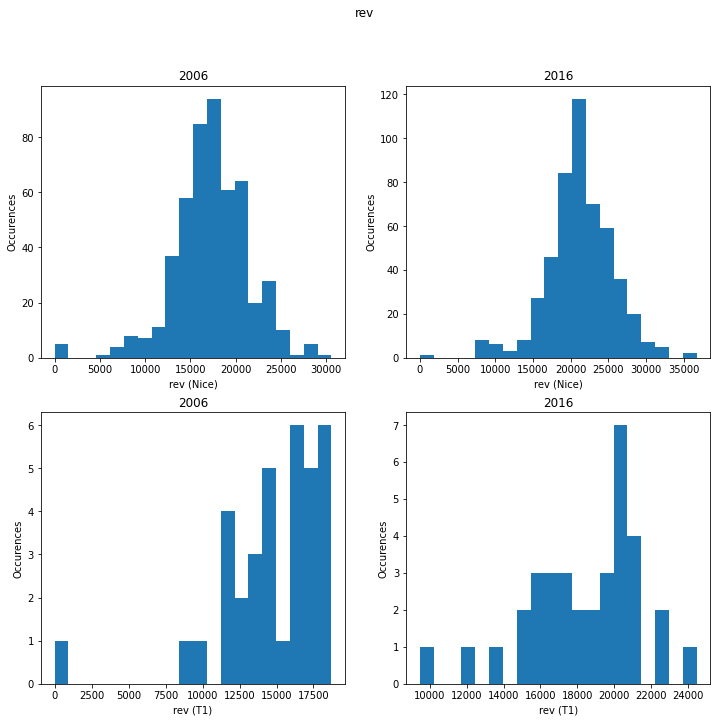

In [35]:
feature_label = 'rev'
draw_hist(bd_gent_2006, bd_gent_2016, bd_gent_2006_T1, bd_gent_2016_T1, feature_label)

## Pearson correlation 🚀

In [36]:
corr = bd_gent_2006_T1_no_tx.corr()

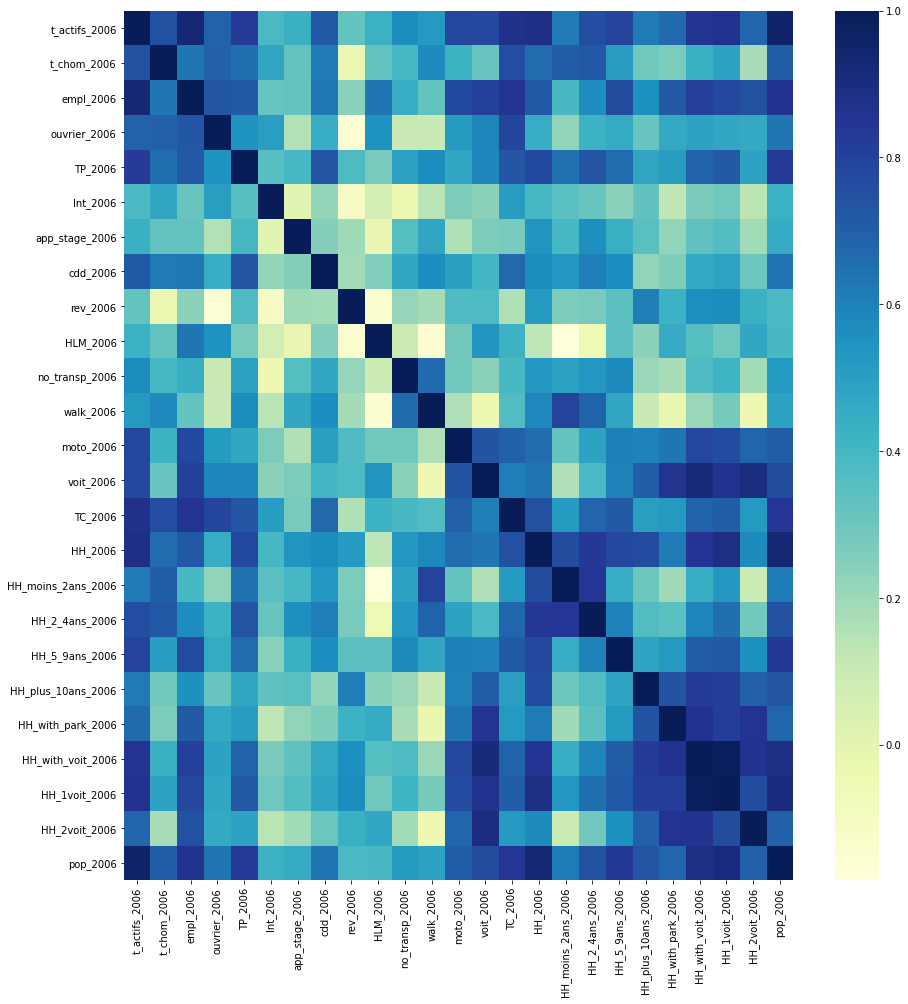

In [37]:
fig, ax = plt.subplots(figsize=(15,16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu")

In [38]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation
corr_df.reset_index(inplace=True, drop=True)
corr_df.head()

,feature_1,feature_2,correlation
0,HH_with_voit_2006,HH_1voit_2006,0.985650
1,HH_1voit_2006,HH_with_voit_2006,0.985650
2,pop_2006,t_actifs_2006,0.955644
3,t_actifs_2006,pop_2006,0.955644
4,pop_2006,HH_2006,0.934751


## Pairplots

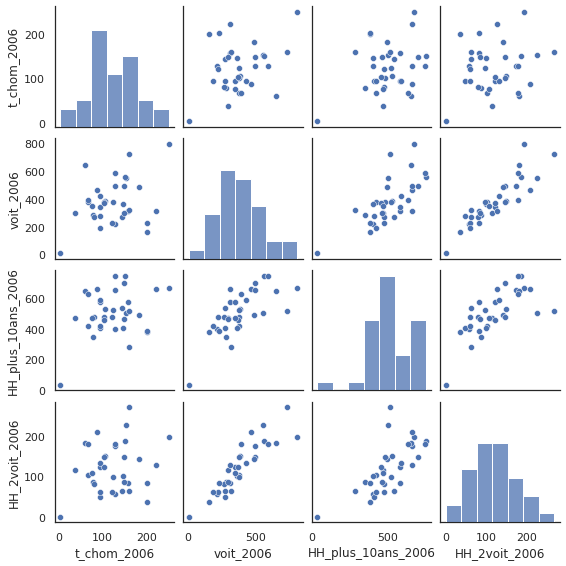

In [39]:
sns.set(style='white')
sns.pairplot(bd_gent_2006_T1_no_tx[['t_chom_2006', 'voit_2006', 'HH_plus_10ans_2006', 'HH_2voit_2006']], height=2)
plt.show()

## Time for a bit of modelling

In [40]:
scaler = StandardScaler()
bd_gent_2006_no_tx__scaled = pd.DataFrame(scaler.fit_transform(bd_gent_2006_no_tx))

In [41]:
bd_gent_2006_no_tx__scaled

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,-1.714062,-1.405301,-1.600521,-1.414266,-1.672565,-1.050387,-1.117092,-1.406525,0.037276,-0.441980,...,-1.755414,-1.377054,-1.550608,-1.641629,-1.753078,-1.389935,-1.676253,-1.613382,-1.172163,-1.783098
1,-1.752267,-1.392832,-1.622930,-1.380994,-1.745915,-1.050387,-1.044585,-1.606899,0.000000,-0.441980,...,-1.815904,-1.390036,-1.594896,-1.684207,-1.838984,-1.433384,-1.731679,-1.650567,-1.234470,-1.842160
2,-1.339602,-1.096228,-1.379529,-0.744432,-1.300650,-0.967871,-0.847253,-0.926122,-0.830894,-0.313854,...,-1.427182,-0.805410,-1.198726,-1.311063,-1.591304,-1.127351,-1.299107,-1.255140,-0.901500,-1.426891
3,-0.727510,-0.347620,-0.667928,-0.231640,-0.308557,-1.050387,-0.392669,-0.553693,0.674834,-0.441980,...,-1.174913,-1.203118,-0.997800,-1.265706,-0.996733,-0.806232,-0.968057,-1.112960,-0.412899,-0.953269
4,0.706071,-0.127060,0.692987,0.151041,1.080576,-0.043860,0.160557,0.338503,0.209269,0.492787,...,0.041915,-0.682168,-0.412954,0.047693,0.547177,0.200423,0.405284,-0.178957,1.112547,0.374482
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.232410,0.230552,0.401718,0.069559,0.234488,0.600585,0.537152,1.156614,0.441810,-0.441980,...,-0.020783,0.743500,0.814342,-0.004673,-0.754553,0.427901,0.245110,0.212210,0.205941,-0.229324
496,1.311306,0.254297,0.603524,-0.515443,0.916902,-1.050387,0.562356,-0.254183,2.076834,-0.441980,...,1.007705,0.758471,1.683754,1.245436,0.445307,1.894751,1.656133,0.662417,2.515517,0.978049
497,0.502033,0.576641,0.045054,0.142210,0.591790,1.027777,1.027932,0.202509,0.737070,-0.441980,...,0.188311,0.390741,0.249070,0.065455,0.110086,0.662954,0.528328,0.302366,0.669820,0.117071
498,-1.292752,-1.269977,-1.046352,-1.015288,-1.341978,-1.050387,-0.893611,-0.743586,-0.714864,-0.383307,...,-1.355169,-1.047740,-1.233864,-1.339408,-1.301845,-1.241416,-1.277576,-1.269055,-0.835974,-1.317423


In [42]:
pca = PCA()

In [43]:
pca.fit(bd_gent_2006_no_tx__scaled)

PCA()

In [44]:
Wt = pd.DataFrame(pca.components_)
Wt

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,2.460823e-01,2.041448e-01,2.378826e-01,1.985912e-01,2.346973e-01,1.587456e-01,1.695817e-01,2.174596e-01,5.255155e-02,8.097275e-02,...,0.244869,0.196769,0.228181,0.235980,0.232853,2.109048e-01,0.237938,0.232603,0.161154,2.491940e-01
1,-7.941634e-02,2.042992e-01,6.989992e-02,1.813967e-01,-3.997282e-02,2.276667e-01,-2.574009e-02,9.376864e-02,-4.451088e-01,2.443601e-01,...,0.001915,0.086389,0.033135,0.018949,-0.056316,-2.677809e-01,-0.175321,0.018431,-0.395329,-4.682129e-02
2,8.541840e-02,1.397155e-01,8.439880e-02,3.082232e-01,8.619210e-02,2.049079e-01,1.639528e-01,-3.474774e-02,-1.949757e-01,5.210479e-01,...,-0.145806,-0.304715,-0.179932,-0.111001,-0.059041,4.414521e-02,-0.018607,-0.167987,0.205667,4.457695e-02
3,2.499559e-02,-3.357823e-03,-2.321413e-02,7.260156e-02,1.278197e-01,-5.746533e-02,3.665864e-01,1.524868e-01,-1.134785e-01,-5.268905e-02,...,-0.079064,-0.032103,-0.069792,-0.103200,-0.074978,-1.547861e-01,-0.092295,-0.212480,0.115625,1.222767e-02
4,5.624962e-02,-2.490100e-01,1.535655e-01,-2.193199e-02,7.566349e-02,8.366035e-02,2.439022e-03,1.687358e-01,3.197439e-01,1.111022e-01,...,-0.120525,-0.363996,-0.289514,-0.139637,0.093075,-1.074342e-01,-0.082581,-0.126521,0.010790,-1.991188e-02
5,6.507452e-02,-1.722728e-01,-3.830473e-02,-1.534066e-04,1.464038e-01,3.121175e-01,5.512120e-01,8.483338e-02,3.427287e-02,-4.185850e-01,...,-0.058091,0.182676,0.052356,-0.155895,-0.145992,-1.118927e-01,-0.082844,-0.147211,0.040386,-5.270169e-02
6,-4.488332e-02,-2.712518e-02,-9.809830e-03,-2.512011e-01,2.821817e-03,-5.838785e-01,5.596685e-01,-8.414398e-02,1.021104e-01,4.033216e-01,...,0.054297,-0.022198,0.048644,0.083436,0.061521,1.467114e-02,-0.002431,0.076142,-0.116054,7.996025e-03
7,9.599849e-02,-8.870498e-02,1.865320e-01,1.636543e-01,2.653112e-02,-5.067712e-01,-5.780953e-02,2.331504e-01,-5.936826e-01,-2.646584e-01,...,-0.056887,-0.064771,-0.023329,-0.057822,-0.060563,6.815929e-02,0.034094,0.009316,0.058081,-1.642296e-02
8,-9.610349e-02,-1.792125e-01,5.898446e-03,-9.529081e-02,-3.266366e-01,2.980294e-01,3.518757e-01,-2.331047e-01,-2.562936e-01,4.356607e-02,...,0.004737,0.062064,0.087031,0.046244,-0.083067,1.783499e-01,0.076609,0.227148,-0.169965,-8.369427e-02
9,7.532551e-03,2.091717e-01,-9.849012e-03,3.601966e-02,-1.377472e-01,-3.904998e-02,-5.080932e-02,4.583938e-01,3.046796e-01,2.622624e-01,...,-0.115720,0.315779,0.180164,-0.037381,-0.456892,-4.761844e-02,-0.037911,-0.017041,-0.054847,-1.300884e-01


In [45]:
bd_gent_2006_no_tx__scaled_PCA = pd.DataFrame(pca.transform(bd_gent_2006_no_tx__scaled))

<AxesSubplot:>

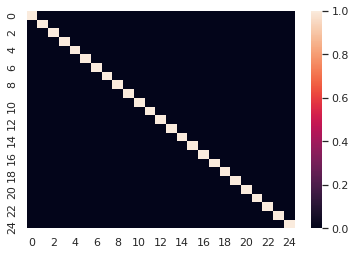

In [46]:
sns.heatmap(bd_gent_2006_no_tx__scaled_PCA.corr())

In [50]:
X_pca = bd_gent_2006_no_tx__scaled_PCA.to_numpy(copy=True) # What was the problem? Wrong datatype expected=numpy, passed:pd.DataFrame

df = pd.DataFrame()
df["vif_index"] = [vif(X_pca, i) for i in range(X_pca.shape[1])]
df

,vif_index
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
5,1.0
6,1.0
7,1.0
8,1.0
9,1.0


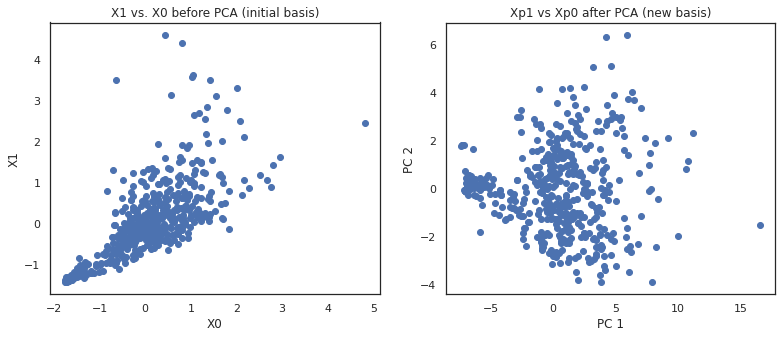

In [51]:
X_scaled = bd_gent_2006_no_tx__scaled.to_numpy()

plt.figure(figsize=(13,5))

plt.subplot(1,2,1)
plt.title('X1 vs. X0 before PCA (initial basis)'); plt.xlabel('X0'); plt.ylabel('X1')
plt.scatter(X_scaled[:,0], X_scaled[:,1])

plt.subplot(1,2,2)
plt.title('Xp1 vs Xp0 after PCA (new basis)'); plt.xlabel('PC 1'); plt.ylabel('PC 2')
plt.scatter(X_pca[:,0], X_pca[:,1])

In [74]:
#'Rank' PC per order of 'importance'
df_Xp = bd_gent_2006_no_tx__scaled_PCA # sample: pd.DataFrame(Xp)
df_Xp.std()**2 / ((df_Xp.std()**2).sum())

0     6.226607e-01
1     1.192597e-01
2     6.605785e-02
3     3.472206e-02
4     2.921721e-02
5     2.399680e-02
6     1.965707e-02
7     1.647492e-02
8     1.325740e-02
9     1.164320e-02
10    8.994005e-03
11    7.629930e-03
12    5.918814e-03
13    4.992670e-03
14    3.902910e-03
15    2.745992e-03
16    2.542808e-03
17    2.230978e-03
18    1.874451e-03
19    1.162267e-03
20    5.985629e-04
21    4.316674e-04
22    2.805053e-05
23    4.179558e-20
24    2.604584e-20
dtype: float64

In [75]:
pca.explained_variance_ratio_

array([6.22660670e-01, 1.19259726e-01, 6.60578522e-02, 3.47220565e-02,
       2.92172059e-02, 2.39967951e-02, 1.96570683e-02, 1.64749240e-02,
       1.32573980e-02, 1.16431987e-02, 8.99400511e-03, 7.62993005e-03,
       5.91881417e-03, 4.99267042e-03, 3.90290982e-03, 2.74599168e-03,
       2.54280799e-03, 2.23097820e-03, 1.87445106e-03, 1.16226651e-03,
       5.98562895e-04, 4.31667400e-04, 2.80505251e-05, 4.17955790e-20,
       2.60458354e-20])

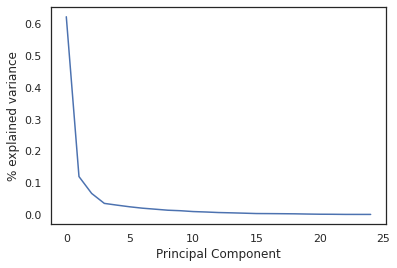

In [76]:
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Principal Component'); 
plt.ylabel('% explained variance');

In [83]:
eig_vals, eig_vecs = np.linalg.eig(np.dot(X.T,X))

NameError: name 'X' is not defined

# KMeans

In [70]:
km = KMeans(n_clusters=3)
km.fit(bd_gent_2006_no_tx__scaled_PCA)

KMeans(n_clusters=3)

Text(0, 0.5, 'PC 2')

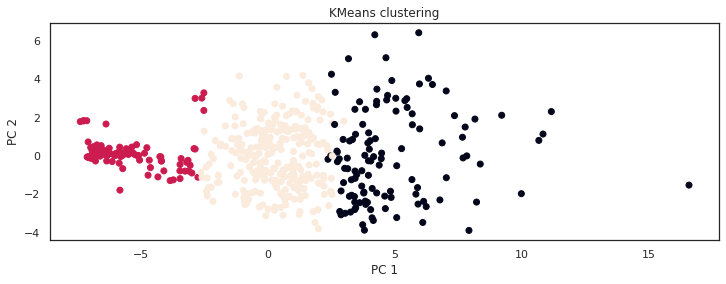

In [71]:
plt.figure(figsize=(12,4))
plt.scatter(X_pca[:,0], X_pca[:,1], c=km.labels_)
plt.title('KMeans clustering'); 
plt.xlabel('PC 1');
plt.ylabel('PC 2')